# Land Cover Change: Houston Urban Growth.

## Introduction

Houston is one of the fastest growing cities in the United States. Over the 1990-2016 period, Harris county (which includes Houston downtown) experienced a 67% increase in population. On the ground, this has led to a strong increase in developed land for urban use. As a geospatial analyst for the Harris County board, you are being asked to explore trends in the Houston Metropolitan area and examine past land change to understand future land development in the county. To complete the task, you will process land cover data from the National Land Cover Database (NLCD) and examine land change in the area. You will also generate a first exploratory land change model using logistic regression to examine proximate factors (variables) that have influenced past location of development. All work must be repeatable and documented in a scripting environment to be shared with your team.

## Documentation and packages

First, we set up the code by providing information on the Authors, Creation dates, version by importing relevant python packages. Documenting and providing context and information within a script is important as it is often the case that code will be reused for other applications or other users/colleagues Good documentation improves code reproducibility as well.

In [1]:
####################################    Spatial Analyses: SYRACUSE   #######################################
#######################################  Analyse data from Census #######################################
#This script performs basic analyses for the Exercise 1 of the workshop using Census data.
# The overall goal is to explore spatial autocorrelation and aggregation of units of analyses.     
#
#AUTHORS: Benoit Parmentier                                             
#DATE CREATED: 12/29/2018 
#DATE MODIFIED: 03/29/2019
#Version: 1
#PROJECT: AAG 2019 workshop preparation
#TO DO:
#
#COMMIT: added Moran'I and spatial regression, AAG workshop
#Useful links:
#sudo mount -t vboxsf C_DRIVE ~/c_drive

##################################################################################################

###### Library used in this script

import gdal
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import subprocess
import pandas as pd
import os, glob
from rasterio import plot
import geopandas as gpd
import descartes
import libpysal as lp #new pysal interface
#from cartopy import crs as ccrs
#import cartopy
from pyproj import Proj
from osgeo import osr
from shapely.geometry import Point
import pysal as ps
from shapely.geometry import shape
import fiona
import os
import splot #for hotspot analysis
from esda.moran import Moran
from libpysal.weights.contiguity import Queen
from sklearn.preprocessing import StandardScaler

The list of packages above constains some of the most common packages used in geospatial data processing, wrangling and analyses. Notables spatial packages are "geopandas", "rasterio", "pysal", "gdal" and "shapely". Geopandas extends the "pandas" package to allow for the use of spatial data using a geometry column in a DataFrame object. It implements a version of the OGC Simple Feature model (https://www.opengeospatial.org/standards/sfa) using the "shapely" package to define the geometry of spatial objects. GDAL and Rasterio allow raster layers operations and processing including reprojection, distance compuation, mosaicing. The "skitlearn" package provides access to Machine Learning method in a unified API interface.. In this exercise, we use scikitlearn to model land cover change with a logistic regression.

## Functions

In the next part of the script, we declare all the functions used in the sripts. The first function builds an output directory. It is good practice to place functions at the beginning of a script or an external source file.

In [2]:

################ NOW FUNCTIONS  ###################

##------------------
# Functions used in the script 
##------------------

def create_dir_and_check_existence(path):
    #Create a new directory
    try:
        os.makedirs(path)
    except:
        print ("directory already exists")


## Parameters and Arguments

It is good practice to set all parameters and input arguments at the beginning of the script. This allows for better control and can make modifications of the scripts for other applications easier. Some arguments relate to path directories, input files and general parameters for use in the analyses (e.g. proportion of hold out).

In [3]:
############################################################################
#####  Parameters and argument set up ########### 

#ARGS 1
#in_dir = "/home/bparmentier/c_drive/Users/bparmentier/Data/python/Exercise_4/data"
in_dir = "/nfs/public-data/training"
#ARGS 2
#out_dir = "/home/bparmentier/c_drive/Users/bparmentier/Data/python/Exercise_4/outputs"
out_dir = "/research-home/bparmentier"
#ARGS 3:
create_out_dir=True #create a new ouput dir if TRUE
#ARGS 4
out_suffix = "exercise4_04052019" #output suffix for the files and ouptut folder
#ARGS 5
NA_value = -9999 # number of cores
#ARGS 6
file_format = ".tif"
#ARGS 7
#NLCD coordinate reference system: we will use this projection rather than TX.
CRS_reg = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"
#ARGS 8
method_proj_val = "bilinear" # method option for the reprojection and resampling
#ARGS 9
gdal_installed = True #if TRUE, GDAL is used to generate distance files
		
### Input data files
#ARGS 10
rastername_county_harris = "harris_county_mask.tif" #Region of interest: extent of Harris County
#ARGS 11
elevation_fname = "srtm_Houston_area_90m.tif" #SRTM elevation
#ARGS 12
roads_fname = "r_roads_Harris.tif" #Road count for Harris county
	
### Aggreagate NLCD input files
 #ARGS 13
infile_land_cover_date1 = "agg_3_r_nlcd2001_Houston.tif"
#ARGS 14
infile_land_cover_date2 = "agg_3_r_nlcd2006_Houston.tif"
#ARGS 15
infile_land_cover_date3 = "agg_3_r_nlcd2011_Houston.tif"
#ARGS 16	
infile_name_nlcd_legend = "nlcd_legend.txt"
#ARGS 17
infile_name_nlcd_classification_system = "classification_system_nlcd_legend.xlsx"
#ARGS 18	
data_fname = 'r_variables_harris_county_exercise4_02072019.txt'
#ARGS 19
prop = 0.3 #proportion of observations for hold-out/testing
#ARGS 20
random_seed = 100 #random seed for reproducibility

## Input and output directories

Before any analyses, we start the script by creating a new output directory to store new files generated througout the script. Separating inputs from outputs avoids overwriting or modifiying the input source files. It is likely that you will repeath the analyses multiples times and generating a new output directory with a date or version can also help in tracking modeling and analyses outputs with different input arguments. 

In [6]:
################# START SCRIPT ###############################

######### PART 0: Set up the output dir ################

#set up the working directory
#Create output directory

if create_out_dir==True:
    out_dir_new = "output_data_"+out_suffix
    out_dir = os.path.join(out_dir,out_dir_new)
    create_dir_and_check_existence(out_dir)
    os.chdir(out_dir)        #set working directory
else:
    os.chdir(create_out_dir) #use working dir defined earlier


directory already exists


## PART 1: Reading visualizing data

Part I consists in reading in census tracks, blocks and block groups from spatial files (shapefiles here) in geopandas DataFrame. The geopandas "read_file" can read many data types as it uses GDAL/OGR drivers to read inputs. We also read in textfile in the "csv" format and excel sheets using the "pandas" package. We explore the datasets by examining the coordinate systems, size (use "shape") and by displaying a few rows of the geopandas/pandas data frames.

<class 'rasterio.io.DatasetReader'>
Coordinate reference system:  PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
 Rows and columns:  (789, 965) number of rows:  789


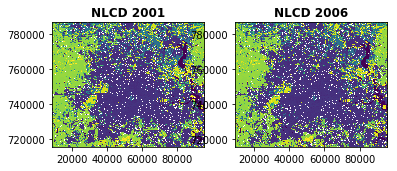

In [9]:
###########################################
###########################################
### PART I: READ AND VISUALIZE DATA #######
	
infile_land_cover_date1 = os.path.join(in_dir,infile_land_cover_date1) #NLCD 2001
infile_land_cover_date2 = os.path.join(in_dir,infile_land_cover_date2) #NLCD 2006
infile_land_cover_date3 = os.path.join(in_dir,infile_land_cover_date3) #NLCD 2011

lc_date1 = rasterio.open(infile_land_cover_date1) 
r_lc_date1 = lc_date1.read(1,masked=True) #read first array with masked value, nan are assigned for NA
lc_date2 = rasterio.open(infile_land_cover_date2) 
r_lc_date2 = lc_date2.read(1,masked=True) #read first array with masked value, nan are assigned for NA
lc_date3= rasterio.open(infile_land_cover_date2) 

#Generate quick visualization using rasterio object
f, ax = plt.subplots(1, 2)
plot.show(lc_date1,title="NLCD 2001",ax=ax[0])
plot.show(lc_date2,title="NLCD 2006",ax=ax[1])

print(type(lc_date1))
print("Coordinate reference system: ",lc_date1.crs ) 
      
print(" Rows and columns: ", lc_date1.shape, "number of rows: ", lc_date1.height)  

lc_legend_df = pd.read_csv(os.path.join(in_dir,infile_name_nlcd_legend),sep=",")
lc_legend_df.head() # Inspect data
lc_legend_df.columns
lc_legend_df.shape
#subset the data to remove unused rows
lc_legend_df = lc_legend_df[lc_legend_df['COUNT']>0] 


## PART 2: Summarize/aggregate poppulation at census track level

We would like to map population and exposure to lead in Syracuse at the census track level. This requires bringing attribute data from the census together with the blockgroup and census track spatial information. 


Text(0.5, 1.0, 'POPULATION 2000')

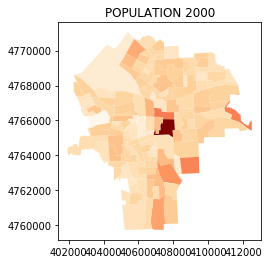

In [140]:
#########################################################
####### PART 2: Visualizing population in 2000 at Census track level with geopandas layers 
#### We explore  also two ways of joining and aggregating data at census track level #########
#### Step 1: First join census information data to blockgroups
#### Step 2: Summarize/aggregate poppulation at census track level ###
#### Step 3: Plot population 2000 by tracks

### Step 1: First join census data to blockgroups

bg_2000_gpd.columns # missing census information:check columns' name for the data frame
census_syr_df.columns #contains census variables to join
#Key is "TRACT" but with a different format/data type
#First fix the format
bg_2000_gpd.head()
bg_2000_gpd.shape
census_syr_df.BKG_KEY.head()
#ct_2000_gpd.TRACT.dtype
census_syr_df.dtypes #check all the data types for all the columns
bg_2000_gpd.BKG_KEY.dtypes #check data type for the "BKG_KEY"" note dtype is "O"
census_syr_df.BKG_KEY.dtypes # check data type, note that it is "int64"

#Change data type for BKG_KEY column from object 'O" to int64
bg_2000_gpd['BKG_KEY'] = bg_2000_gpd['BKG_KEY'].astype('int64')

# Join data based on common ID after matching data types
bg_2000_gpd = bg_2000_gpd.merge(census_syr_df, on='BKG_KEY')
# Check if data has been joined 
bg_2000_gpd.head()

#Quick visualization of population 
bg_2000_gpd.plot(column='POP2000',cmap="OrRd")
plt.title('POPULATION 2000')


### Method 1: Summarize by census track using DISSOLVE geospatial operation

We explore two ways of joining and aggregating data at census track level. In method 1, we dissolve boundaries from blockgroups using the "TRACT" key. The "dissolve" operator allow for various aggregation functions. We request "sum" to summarize all the columns/field by tract using summation.


In [153]:
#############
#### Step 2: Summarize/aggregate poppulation at census track level

### Method 1: Summarize by census track using DISSOLVE geospatial operation

#To keep geometry, we must use dissolve method from geopanda
census_2000_gpd = bg_2000_gpd.dissolve(by='TRACT',
                                       aggfunc='sum')
type(census_2000_gpd)
census_2000_gpd.index
#Note that the TRACT field has become the index
census_2000_gpd=census_2000_gpd.reset_index() # reset before comparing data
census_2000_gpd.shape #Dissolved results shows aggregation from 147 to 57.


(57, 44)

## Method 2: Summarize using groupby aggregation and joining

This method uses "groupby" to aggregation information by census track using a summary function. We use here "sum" to generate summary at the census track level. Note that the output of the gropuby operation is a pandas DataFrame. The output table is then join to the census track level geopanda DataFrame using the track ID as the primary key. Before joing the datasets, we must ensure that the datatypes of both keys match and change the column data type us "astype" if necessary. The join operation is carried out using the merge function. 


In [142]:
### Method 2: Summarize using groupby aggregation and joining

##Note losing TRACT field
census_2000_df = bg_2000_gpd.groupby('TRACT',as_index=False).sum()
type(census_2000_df) #This is a panda object, we lost the geometry after the groupby operation.
census_2000_df.shape #Groupby results shows aggregation from 147 to 57.

### Let's join the dataFrame to the geopanda object to the census track layer 
census_2000_df['TRACT'].dtype == ct_2000_gpd['TRACT'].dtype #Note that the data type for the common Key does not mach.  
census_2000_df['TRACT'].dtype # check data type field from table
ct_2000_gpd['TRACT'].dtype # check data type field from census geopanda layer
ct_2000_gpd['TRACT'] = ct_2000_gpd.TRACT.astype('int64') #Change data type to int64
ct_2000_gpd.shape #57 rows and 8 columns

ct_2000_gpd = ct_2000_gpd.merge(census_2000_df, on='TRACT')
print("Shape of census tracks geo DataFrame :", ct_2000_gpd.shape) #57 rows and 50 columns

ct_2000_gpd.head()

Shape of census tracks geo DataFrame : (57, 50)


,FIPS,STATE_FIPS,CNTY_FIPS,STCOFIPS,TRACT,Shape_Leng_x,Shape_Area_x,geometry,BKG_KEY,Shape_Leng_y,...,MARHH_NO_C,MHH_CHILD,FHH_CHILD,FAMILIES,AVE_FAM_SZ,HSE_UNITS,VACANT,OWNER_OCC,RENTER_OCC,perc_hispa
0,36067000100,36,067,36067,100,13520.232628,6.135184e+06,"POLYGON ((403476.3667961732 4767681.659353677,...",360670001001,13520.232628,...,45,3,10,74,2.36,309,47,88,174,0.030534
1,36067000300,36,067,36067,300,3664.906267,5.528384e+05,"POLYGON ((407273.7082073092 4770615.348040303,...",721340006003,5225.175499,...,157,16,69,408,5.96,716,41,463,212,0.077622
2,36067000200,36,067,36067,200,4620.537302,1.084286e+06,"POLYGON ((405762.8405454708 4770677.466250783,...",721340004003,6038.106998,...,246,45,162,739,6.27,1627,210,582,835,0.075676
3,36067000400,36,067,36067,400,5931.046228,1.513148e+06,"POLYGON ((408398.5954386378 4769563.645143542,...",1442680016010,11971.493374,...,386,26,133,925,11.56,1650,99,1091,460,0.036988
4,36067001000,36,067,36067,1000,5668.226852,1.237272e+06,"POLYGON ((409917.2280338025 4769065.286384709,...",1442680040010,10786.395771,...,341,38,207,886,11.08,2232,159,688,1385,0.166031


### Plotting population at census track level in Syracuse

Once the datasets are joined, we can generate chloropleth maps of poppulation by census tracks for the year 2000 using the geopandas and matplotlib packages. The parameter "scheme" allow for different class interval to display value ranges on the map.

Text(0.5, 1.0, 'POP2000')

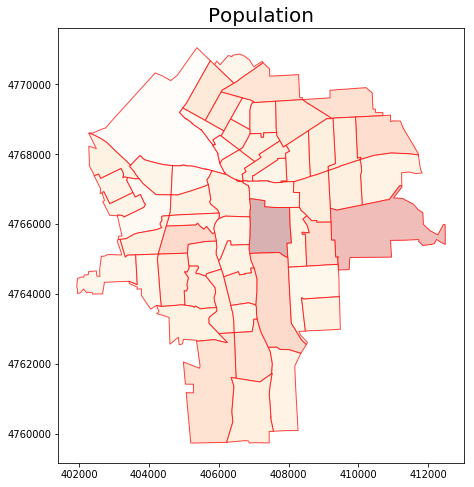

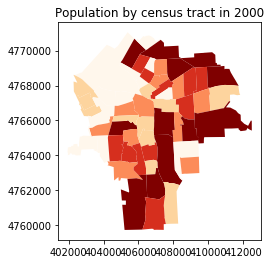

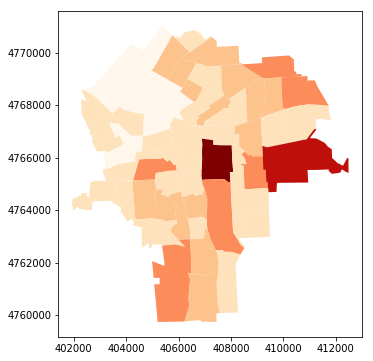

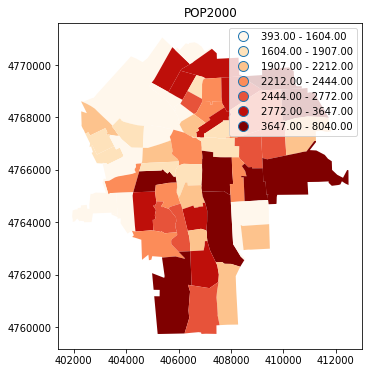

In [143]:
#### Step 3: Plot population 2000 by tracks in Syracuse

### Check if the new geometry of entities is the same as census
fig, ax = plt.subplots(figsize=(12,8))
ax.set_aspect('equal') # set aspect to equal, done automatically in *geopandas* plot but not in pyplot
census_2000_gpd.plot(ax=ax,column='POP2000',cmap='OrRd')
ct_2000_gpd.plot(ax=ax,color='white',edgecolor="red",alpha=0.7) # Check if outputs from two methods match
ax.set_title("Population", fontsize= 20)

#### Generate population maps with two different class intervals

title_str = "Population by census tract in 2000"
census_2000_gpd.plot(column='POP2000',cmap="OrRd",
                 scheme='quantiles')
plt.title(title_str)

### Let's use more option with matplotlib

fig, ax = plt.subplots(figsize=(14,6))
census_2000_gpd.plot(column='POP2000',cmap="OrRd",
                 scheme='equal_interval',k=7,
                 ax=ax,
                 legend=False)

fig, ax = plt.subplots(figsize=(14,6))
census_2000_gpd.plot(column='POP2000',cmap="OrRd",
                 scheme='quantiles',k=7,
                 ax=ax,
                 legend=True)
ax.set_title('POP2000')


## PART 3: SPATIAL QUERY 

We generate a dataset with metals and lead information by census tracks.
This requires multiple steps. First, we need to join metals attribute to census tracks. Second, we generate a spatial object from the textfile of lead (PB) data. This files contains x and y coordinates that can be used to create a POINT geometry column using the shapely and geopandas packages.
The third step consists in joining the lead data to census tracks. This is done through a spatial join to associate point data with polygons identifiers containing them. The fourth step consists in using a summarize by operation ("groupby") to generate averages of lead ppm by census tracks.


,x,y,ID,ppm,Coordinates
0,408164.2892,4762321.061,0,3.890648,POINT (408164.2892 4762321.061000001)
1,405914.8759,4767394.274,1,4.899391,POINT (405914.8759 4767394.274)
2,405723.9622,4767705.893,2,4.434912,POINT (405723.9622 4767705.893)
3,406702.7734,4769200.832,3,5.285548,POINT (406702.7734 4769200.831999999)
4,405392.3004,4765598.492,4,5.295919,POINT (405392.3004 4765598.492)


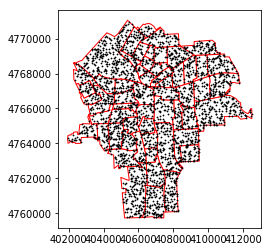

In [144]:
##### Step 1: Join metals to census tracks ###### 

metals_df.head()
metals_df.describe() # 57 rows  
##Number of rows suggests matching to the following spatial entities
metals_df.shape[0]== ct_2000_gpd.shape[0]
#Check data types before joining tables with "merge"
metals_df.dtypes
ct_2000_gpd.dtypes
ct_2000_gpd.shape
census_metals_gpd = ct_2000_gpd.merge(metals_df,left_on='TRACT',right_on='ID')
census_metals_gpd.shape #census information has been joined

##### Step 2: Generate geopanda from PB sample measurements ##### 
# Processing lead data to generate a geopanda object using shapely points

soil_PB_df.columns #Missing names for columns
soil_PB_df.columns = ["x","y","ID","ppm"]
soil_PB_df.head()

soil_PB_gpd = soil_PB_df.copy() # generate a new panda DataFrame object
type(soil_PB_gpd)
soil_PB_gpd['Coordinates']=list(zip(soil_PB_gpd.x,soil_PB_gpd.y)) #create a new column with tuples of coordinates
type(soil_PB_gpd)
soil_PB_gpd['Coordinates']= soil_PB_gpd.Coordinates.apply(Point) #create a point for each tupple row
type(soil_PB_gpd.Coordinates[0]) #This shows that we created a shapely geometry point
type(soil_PB_gpd) #This is still an panda DataFrame
soil_PB_gpd = gpd.GeoDataFrame(soil_PB_gpd,geometry='Coordinates') #Create a gpd by setting the geometry column
type(soil_PB_gpd) # This is now a GeoDataFrame

## Checking and setting the coordinates reference system
soil_PB_gpd.crs #No coordinate reference system (CRS) is set
census_metals_gpd.crs # Let's use the metal geopanda object to set the CRS

## Find out more about the CRS using the epsg code
epsg_code = census_metals_gpd.crs.get('init').split(':')[1]
inproj = osr.SpatialReference()
inproj.ImportFromEPSG(int(epsg_code))
inproj.ExportToProj4() # UTM 18: this is the coordinate system in Proj4 format
## Assign projection system
soil_PB_gpd.crs= census_metals_gpd.crs #No coordinate system is set
soil_PB_gpd.head()

## Now plot the points
fig, ax = plt.subplots()
census_metals_gpd.plot(ax=ax,color='white',edgecolor='red')
soil_PB_gpd.plot(ax=ax,marker='*',
                 color='black',
                 markersize=0.8)

soil_PB_gpd.head()

In [145]:
##### Step 3: Join lead (pb) measurements to census tracks #####
# Spatial query: associate points of pb measurements to each census tract

soil_PB_joined_gpd =gpd.tools.sjoin(soil_PB_gpd,census_2000_gpd,
                     how="left")
soil_PB_joined_gpd.columns
soil_PB_joined_gpd.shape #every point is associated with information from the census track it is contained in

len(soil_PB_joined_gpd.BKG_KEY.value_counts()) #associated BKG Key to points: 57 unique identifiers
len(soil_PB_joined_gpd.index_right.value_counts()) #associated BKG Key to points: 57 unique identifiers

#### Step 4: Find average lead by census track #####

grouped_PB_ct_df = soil_PB_joined_gpd[['ppm','TRACT','index_right']].groupby(['index_right']).mean() #compute average by census track
grouped_PB_ct_df = grouped_PB_ct_df.reset_index()
grouped_PB_ct_df.shape
grouped_PB_ct_df.head()

grouped_PB_ct_df = grouped_PB_ct_df.rename(columns={'ppm': 'pb_ppm' })
type(grouped_PB_ct_df)

census_metals_gpd = census_metals_gpd.merge(grouped_PB_ct_df,on="TRACT")
census_metals_gpd.shape
census_metals_gpd.columns #check for duplicate columns

outfile_metals_shp = "census_metals_pb_"+'_'+out_suffix+'.shp'
census_metals_gpd.to_file(os.path.join(outfile_metals_shp))

census_metals_df = pd.DataFrame(census_metals_gpd.drop(columns='geometry'))
outfile = "census_metals_pb_"+'_'+out_suffix+'.csv'

census_metals_df.to_csv(os.path.join(outfile))

census_metals_gpd.head()

,FIPS,STATE_FIPS,CNTY_FIPS,STCOFIPS,TRACT,Shape_Leng_x,Shape_Area_x,geometry,BKG_KEY,Shape_Leng_y,...,SSR,MRB,SRB,MZN,SZN,MPB,SPB,Tspbr,index_right,pb_ppm
0,36067000100,36,067,36067,100,13520.232628,6.135184e+06,"POLYGON ((403476.3667961732 4767681.659353677,...",360670001001,13520.232628,...,126.08,40.22,9.29,482.55,819.77,187.54,141.07,4.949256,0,4.928121
1,36067000300,36,067,36067,300,3664.906267,5.528384e+05,"POLYGON ((407273.7082073092 4770615.348040303,...",721340006003,5225.175499,...,126.21,53.21,9.66,239.04,117.44,190.25,125.28,4.830551,2,5.049756
2,36067000200,36,067,36067,200,4620.537302,1.084286e+06,"POLYGON ((405762.8405454708 4770677.466250783,...",721340004003,6038.106998,...,95.41,47.03,8.36,419.25,428.99,492.36,798.56,6.682810,1,5.377026
3,36067000400,36,067,36067,400,5931.046228,1.513148e+06,"POLYGON ((408398.5954386378 4769563.645143542,...",1442680016010,11971.493374,...,75.92,47.77,8.48,292.71,194.48,258.17,196.57,5.281019,3,4.756565
4,36067001000,36,067,36067,1000,5668.226852,1.237272e+06,"POLYGON ((409917.2280338025 4769065.286384709,...",1442680040010,10786.395771,...,35.50,47.20,7.79,220.03,129.71,133.34,74.52,4.311068,9,4.690085


## PART IV: Spatial regression: Vulnerability to metals 

In this section, we examine the relationship between lead and vulnerable populations in Syracuse using first a linear OLS regression and then a spatial lag regression model. Spatial datasets often contain autocorrelation and this must be taken into account when regression models are performed. In the first step, we explor the neighbor structure of the dataset using pysal objects.  In the econd step, we explore spatial autocorrelation using the Moran's I index.


Text(0.5, 1.0, 'Queen Neighbors links')

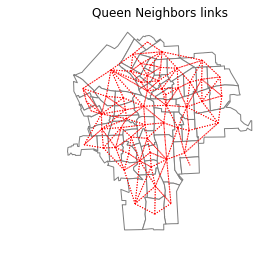

In [157]:
#################################################
##### PART IV: Spatial regression: Vulnerability to metals #############
#Examine the relationship between  Pb and vulnerable populations in Syracuse

######## Step 1: Explore neighbors with pysal

w = Queen.from_dataframe(census_metals_gpd)
type(w)
w.transform = 'r'
w.n # number of observations (spatial features)
census_metals_gpd.index #this is the index used for neighbors
w.neighbors # list of neighbours per census track
w.mean_neighbors #average number of neighbours

### Visualizaing neighbors:
ax = census_metals_gpd.plot(edgecolor='grey', 
                            facecolor='w')
f,ax = w.plot(census_metals_gpd, ax=ax, 
        edge_kws=dict(color='r', linestyle=':', 
                      linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off()
ax.set_title("Queen Neighbors links")




Text(0.5, 1.0, "Moran's scatter plot")

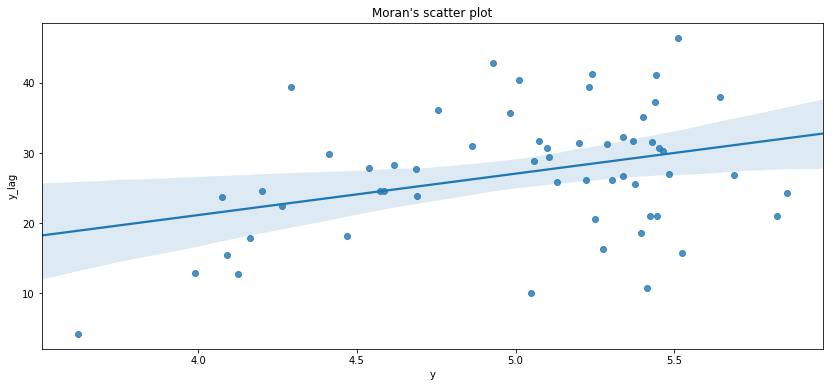

In [167]:
########## Step 2: Explore Moran's I ##########

#http://pysal.org/notebooks/viz/splot/esda_morans_viz
y = census_metals_gpd['pb_ppm'] 
#w_queen = ps.lib.weights.Queen.from_shapefile(outfile_metals_shp)
w_queen = ps.lib.weights.Queen.from_dataframe(census_metals_gpd)

y_lag = ps.model.spreg.lag_spatial(w_queen,y)
census_metals_gpd['y'] = census_metals_gpd['pb_ppm']
census_metals_gpd['y_lag'] = y_lag

fig, ax = plt.subplots(figsize=(14,6))

ax= sns.regplot(x='y',y='y_lag',data=census_metals_gpd)
ax.set_title("Moran's scatter plot")


0.001

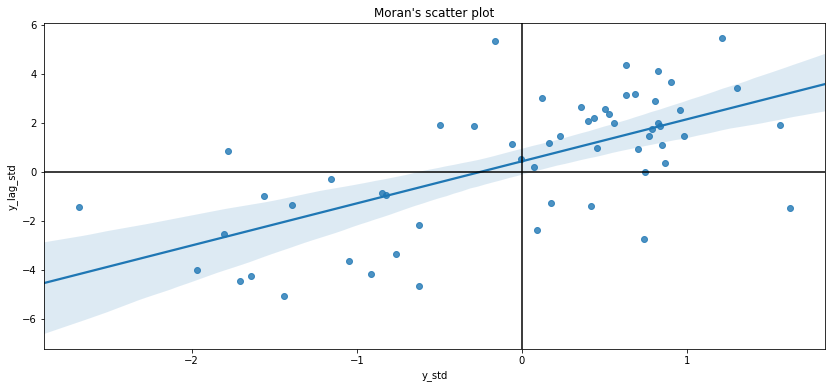

In [168]:
### Visualize the Moran's I with standardized values
scaler = StandardScaler()
census_metals_gpd['y_std'] = scaler.fit_transform(census_metals_gpd['pb_ppm'].values.reshape(-1,1))
census_metals_gpd['y_lag_std'] = ps.model.spreg.lag_spatial(w_queen,
                                                census_metals_gpd['y_std']) #this is a numpy array

fig, ax = plt.subplots(figsize=(14,6))

ax= sns.regplot(x='y_std',y='y_lag_std',data=census_metals_gpd)
ax.set_title("Moran's scatter plot")
ax.axhline(0, color='black')
ax.axvline(0, color='black')
#for more in depth understanding take a look at: http://darribas.org/gds15/content/labs/lab_06.html

#This suggests autocorrelation.
#Let's us Moran's I.

moran = Moran(y, w)
moran.I # Moran's I value
moran.p_sim # Permutation test suggests that autocorrelation is significant


In [166]:

########## Step 3: Spatial Regression ##########

y.values.shape #not the right dimension
y = y.values.reshape(len(y),1)

y_lag = y_lag.reshape(len(y_lag),1)
x = census_metals_gpd['perc_hispa']
x = x.values.reshape(len(x),1)

mod_ols = ps.model.spreg.OLS(y,x)
mod_ols.u 
m_I_residuals = ps.explore.esda.Moran(mod_ols.u,w_queen)
m_I_residuals.I
m_I_residuals.p_sim #significant autocorrelation

#take into account autocorr in spreg
print(mod_ols.summary)
mod_ols_test = ps.model.spreg.OLS(y,x,w_queen)
mod_ols_test.summary

mod_ml_lag = ps.model.spreg.ML_Lag(y,x,w_queen)
print(mod_ml_lag.summary)
mod_ml_lag.u
m_ml_I_residuals = ps.explore.esda.Moran(mod_ml_lag.u,w_queen)
m_ml_I_residuals.I # Moran's I is lower now!!!

m_ml_I_residuals.p_sim #not significant autocorrelation

################################## END OF SCRIPT ########################################


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :     dep_var                Number of Observations:          57
Mean dependent var  :      5.0126                Number of Variables   :           2
S.D. dependent var  :      0.5238                Degrees of Freedom    :          55
R-squared           :      0.0383
Adjusted R-squared  :      0.0209
Sum squared residual:      14.777                F-statistic           :      2.1928
Sigma-square        :       0.269                Prob(F-statistic)     :      0.1444
S.E. of regression  :       0.518                Log likelihood        :     -42.405
Sigma-square ML     :       0.259                Akaike info criterion :      88.810
S.E of regression ML:      0.5092                Schwarz criterion     :      92.896

-----------------------------------------------------------------------------

/usr/local/lib/python3.5/dist-packages/scipy/optimize/_minimize.py:761: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


0.122

## Conclusions

In this exercise, we explored lead exposure in Syracuse. We used spatial information from the census and smaple points of lead collected at various locations. To generate a regression model, we went through a series of processing steps that are typical of geospatial workflows. This include operations such as join, dissolve, aggregation and spatial query based on locations. We explored  spatial autocorrelation using the Moran's I index. We found autocorrelation in the residuals of the OLS regressiona and specified a spatial regression model to take into account spatial autocorrelation. 

## References

PySAL: A Python Library of Spatial Analytical Methods, Rey, S.J. and L. Anselin, Review of Regional Studies 37, 5-27 2007.

Moran, P. A. P. (1950). "Notes on Continuous Stochastic Phenomena". Biometrika. 37 (1): 17–23. doi:10.2307/2332142. JSTOR 2332142.

Impacts of positional error on spatial regression analysis: a case study of address locations in Syracuse, New York. DA Griffith, M Millones, M Vincent, DL Johnson, A Hunt - Transactions in GIS, 2007

Cliff and Ord (1981), Spatial Processes, London
